In [ ]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import platform
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import timedelta

# 한글 폰트 설정
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':  # MacOS
    rc('font', family='AppleGothic')
else:
    print("Unsupported OS")

path = '../dataset/data/'
# CSV 파일 로드
blog_df = pd.read_csv(path + "BLOG.csv")
buy_list_df = pd.read_csv(path + 'BUY_LIST.csv')
deal_list_df = pd.read_csv(path + 'DEAL_LIST.csv')
release_price_df = pd.read_csv(path + 'RELEASE_PRICE.csv')
sell_list_df = pd.read_csv(path + 'SELL_LIST.csv')

# deal_list_df 데이터를 날짜별로 묶어서 price의 평균값 계산
deal_list_df['date'] = pd.to_datetime(deal_list_df['date'], format='%y/%m/%d')
deal_avg_df = deal_list_df.groupby(['model', 'date']).agg({'price': 'mean'}).reset_index()

# 데이터 결합
merged_df = deal_avg_df.merge(blog_df, on='model', how='left')\
                       .merge(buy_list_df.groupby('model').agg({'b_price': 'mean', 'b_count': 'sum'}).reset_index(), on='model', how='left')\
                       .merge(release_price_df.reset_index(), on='model', how='left')\
                       .merge(sell_list_df.groupby('model').agg({'s_price': 'mean', 's_count': 'sum'}).reset_index(), on='model', how='left')

print(merged_df)

# 결측값 처리: 결측값이 많은 컬럼 제거
threshold = 0.3  # 30% 이상의 결측값이 있는 컬럼은 제거
missing_percentage = merged_df.isnull().sum() / len(merged_df)
columns_to_drop = missing_percentage[missing_percentage > threshold].index
merged_df = merged_df.drop(columns=columns_to_drop)

# 나머지 결측값 처리: 평균값으로 채움
merged_df.fillna(merged_df.mean(numeric_only=True), inplace=True)

# 새로운 특성 생성
merged_df['price_ratio'] = merged_df['s_price'] / merged_df['b_price']

# 로그 변환: price에 로그 변환 적용
merged_df['log_price'] = np.log1p(merged_df['price'])

# 날짜 열 변환 (YY/MM/DD 형식)
merged_df['date'] = pd.to_datetime(merged_df['date'], format='%y/%m/%d')
merged_df = merged_df.sort_values('date')

# 시계열 특성 생성
def create_features(df):
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    return df

# 특성 생성
merged_df = create_features(merged_df)

# X값과 y값 분리 
X = merged_df[['total', 'b_price', 'release_price', 's_price', 'price_ratio', 'year', 'month', 'day', 'dayofweek']]
y = merged_df['log_price']

# 특성 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 학습 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 여러 모델 정의
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# 모델 학습 및 평가
best_model = None
best_score = np.inf  # MAE가 낮을수록 더 좋은 모델이므로 초기값을 큰 값으로 설정

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name} - MAE: {mae}, MSE: {mse}")
    if mae < best_score:
        best_score = mae
        best_model = model

print(f"Best Model: {best_model.__class__.__name__} with MAE: {best_score}")

# 선택된 모델 저장
joblib.dump(best_model, '../models/' + best_model.__class__.__name__ + '.pkl')
joblib.dump(scaler, '../models/scaler.pkl')
print('모델과 스케일러 저장 완료')


                             model       date         price  total  \
0      (GS) 나이키 코르테즈 베이직 SL 화이트 블랙 2024-05-21  89454.545455  393.0   
1      (GS) 나이키 코르테즈 베이직 SL 화이트 블랙 2024-05-22  87733.333333  393.0   
2      (GS) 나이키 코르테즈 베이직 SL 화이트 블랙 2024-05-23  87769.230769  393.0   
3      (GS) 나이키 코르테즈 베이직 SL 화이트 블랙 2024-05-24  82000.000000  393.0   
4      (GS) 나이키 코르테즈 베이직 SL 화이트 블랙 2024-05-25  89200.000000  393.0   
...                            ...        ...           ...    ...   
36328                 휠라 인터런 핑크 블랙 2024-05-30  83500.000000   57.0   
36329                 휠라 인터런 핑크 블랙 2024-05-31  81714.285714   57.0   
36330                 휠라 인터런 핑크 블랙 2024-06-01  82600.000000   57.0   
36331                 휠라 인터런 핑크 블랙 2024-06-02  83000.000000   57.0   
36332                 휠라 인터런 핑크 블랙 2024-06-03  80714.285714   57.0   

            b_price  b_count  index  release_price        s_price  s_count  
0               NaN      NaN  195.0        69000.0  104329.113924    105.0  
1    

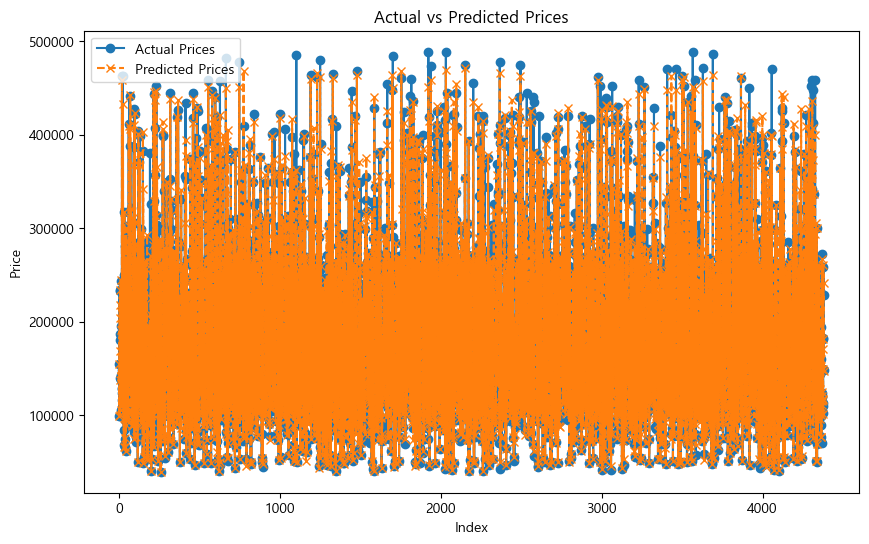

In [21]:
# 예측 값과 실제 값을 시각화하는 코드

# 실제 값과 예측 값 복원 (로그 변환을 적용했으므로, 원래 스케일로 변환)
y_test_original = np.expm1(y_test)
y_pred_original = np.expm1(y_pred)

# 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(y_test_original.values, label='Actual Prices', linestyle='-', marker='o')
plt.plot(y_pred_original, label='Predicted Prices', linestyle='--', marker='x')
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices')
plt.legend()
plt.show()


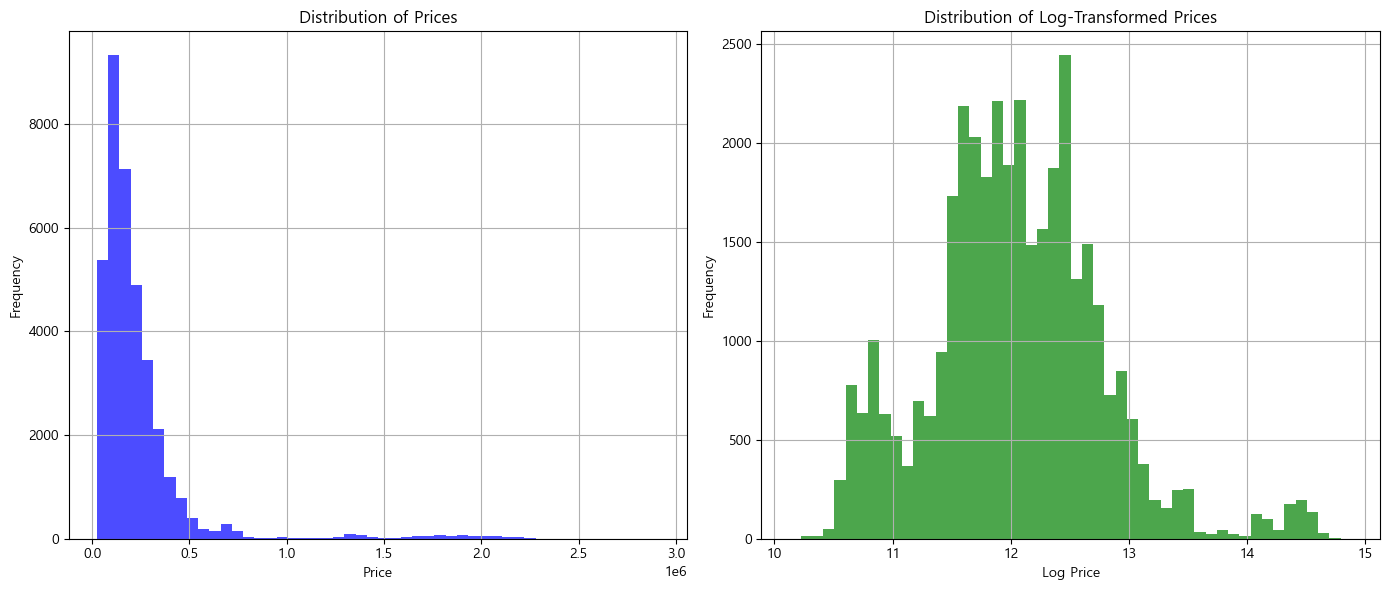

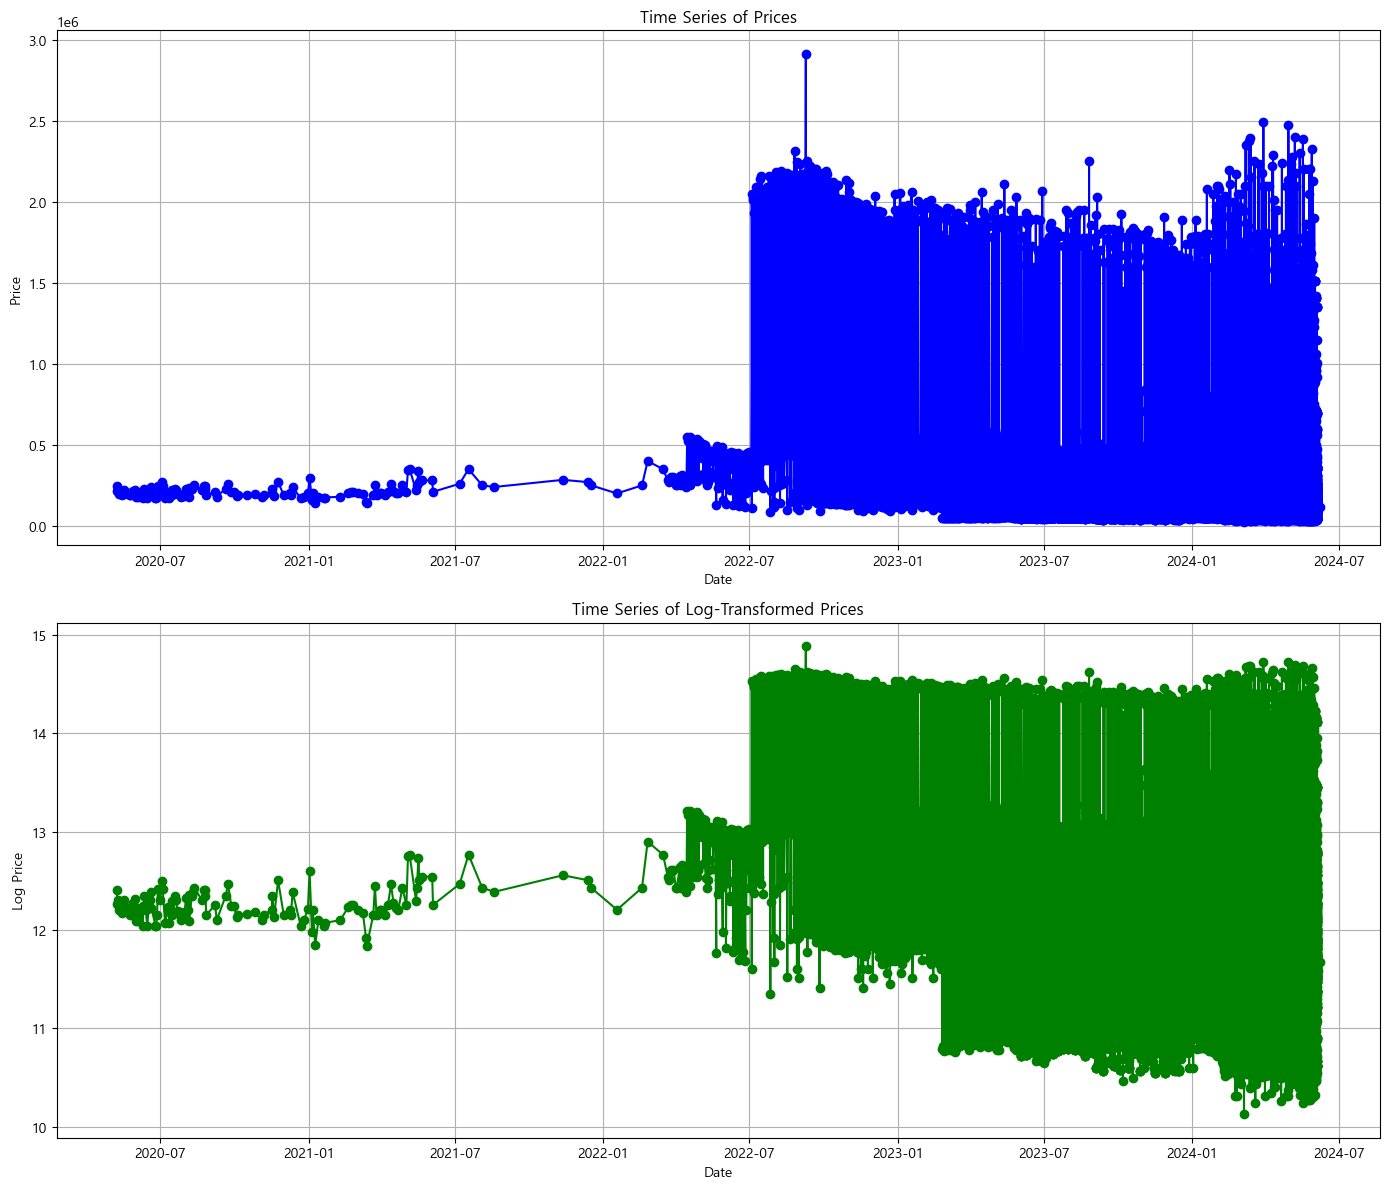

In [5]:
import matplotlib.pyplot as plt

# 히스토그램 비교
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(merged_df['price'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(merged_df['log_price'], bins=50, color='green', alpha=0.7)
plt.title('Distribution of Log-Transformed Prices')
plt.xlabel('Log Price')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()

# 시계열 그래프 비교
plt.figure(figsize=(14, 12))

plt.subplot(2, 1, 1)
plt.plot(merged_df['date'], merged_df['price'], marker='o', linestyle='-', color='blue')
plt.title('Time Series of Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(merged_df['date'], merged_df['log_price'], marker='o', linestyle='-', color='green')
plt.title('Time Series of Log-Transformed Prices')
plt.xlabel('Date')
plt.ylabel('Log Price')
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import font_manager, rc
import platform

# 한글 폰트 설정
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':  # MacOS
    rc('font', family='AppleGothic')
else:
    print("Unsupported OS")

# CSV 파일 로드
buy_list_df = pd.read_csv('../dataset/data/BUY_LIST.csv')
sell_list_df = pd.read_csv('../dataset/data/SELL_LIST.csv')

def visualize_prices(model_name, buy_data, sell_data):
    # 특정 모델 이름으로 데이터 필터링
    buy_model_data = buy_data[buy_data['model'] == model_name]
    sell_model_data = sell_data[sell_data['model'] == model_name]
    
    if buy_model_data.empty and sell_model_data.empty:
        print(f"No data found for model: {model_name}")
        return

    plt.figure(figsize=(14, 7))

    # buy_list_df의 b_price 시각화
    if not buy_model_data.empty:
        plt.hist(buy_model_data['b_price'], bins=20, alpha=0.5, label='Buy Price', color='r')

    # sell_list_df의 s_price 시각화
    if not sell_model_data.empty:
        plt.hist(sell_model_data['s_price'], bins=20, alpha=0.5, label='Sell Price', color='b')

    plt.title(f'Price Distribution for {model_name}')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

# 신발 모델 이름 입력 받기
model_name = input("Enter the shoe model name: ")

# 시각화 함수 호출
visualize_prices(model_name, buy_list_df, sell_list_df)